In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [2]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [3]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6), save_path=None):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle(
                    (j, self.size - i - 1), 1, 1,
                    edgecolor='gray', facecolor=color,
                    linewidth=0.8  # Aumenta grosor para que se note más
                )
                ax.add_patch(rect)

        ax.set_xlim(-0.1, self.size + 0.1)
        ax.set_ylim(-0.1, self.size + 0.1)
        ax.set_aspect('equal')
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, format=save_path.split('.')[-1], dpi=300)
            plt.close(fig)
        else:
            plt.show()




In [4]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red hexagonal", figsize=(6, 6), save_path=None):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)
        dx = 3 ** 0.5
        dy = 1.5
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"
                hexagon = patches.RegularPolygon(
                    (x, y), numVertices=6, radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray', facecolor=color, linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, format=save_path.split('.')[-1], dpi=300)
        else:
            plt.show()





In [5]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = np.array(time_array, dtype=float)
        self.time = float(self.time_array[0])

        # Históricos y snapshots
        self.occupancy = {float(t): None for t in self.time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []

        # Snapshots (lattices y tiempos en paralelo)
        self.lattices = []
        self.snapshot_times = []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================
    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            p = self.processes["diffusion"]
            E_diff = p["e_diff"] + p.get("e_int_diff", 0) * n_ij
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Energía
    # ===================
    def calculate_total_energy(self):
        total_energy = 0
        for i in range(self.lattice.size):
            for j in range(self.lattice.size):
                if self.lattice.lattice[i, j] == 1:
                    n_ij = self.count_occupied_neighbors((i, j))
                    e_ads = self.processes["adsorption"]["e_ads"]
                    e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
                    total_energy += e_ads + e_int_abs * n_ij
        return total_energy

    # ===================
    #     Simulación
    # ===================
    def run_simulation(self):
        end_time = float(self.time_array[-1])

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += float(delta_t)

            event = self.select_event(rates)
            self._apply_event(event, site)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        """
        Si el tiempo actual ya sobrepasó algún t pendiente en time_array,
        guardamos: ocupación, energía y un copy del lattice.
        """
        for t in self.time_array:
            t = float(t)
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = float(self.lattice.get_occupancy() * 100.0)
                self.energies.append(self.calculate_total_energy())
                self.lattices.append(self.lattice.lattice.copy())
                self.snapshot_times.append(t)

    def _capture_remaining_snapshots(self):
        """
        Asegura que todos los tiempos en time_array tengan snapshot.
        Además, guarda el lattice final cuando haga falta.
        """
        for t in self.time_array:
            t = float(t)
            if self.occupancy[t] is None:
                self.occupancy[t] = float(self.lattice.get_occupancy() * 100.0)
                self.energies.append(self.calculate_total_energy())
                self.lattices.append(self.lattice.lattice.copy())
                self.snapshot_times.append(t)

    # ===================
    #     Utilidades
    # ===================
    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {float(t): None for t in self.time_array}
        self.energies.clear()
        self.lattices.clear()
        self.snapshot_times.clear()
        self.events_count = {p: 0 for p in self.processes}
        self.events_history = {p: [] for p in self.processes}
        self.time = float(self.time_array[0])

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)

    def get_curve_series(self):
        """
        Devuelve tiempos y ocupaciones en el orden de captura para la curva.
        """
        times = list(self.snapshot_times)
        occs = [self.occupancy[t] for t in times]
        return times, occs

    def make_gif(self, output_path="evolucion_kmc.gif", step=1, dpi=120, duration_ms=200):
        if len(self.lattices) == 0 or len(self.snapshot_times) == 0:
            raise RuntimeError("No hay snapshots. Ejecuta run_simulation() primero.")

        frames = []
        indices = list(range(0, len(self.snapshot_times), max(1, int(step))))
        if indices[-1] != len(self.snapshot_times) - 1:
            indices.append(len(self.snapshot_times) - 1)

        all_times, all_occs = self.get_curve_series()

        # Guardar tamaño de la red para fijar límites
        Lx, Ly = self.lattices[0].shape[1], self.lattices[0].shape[0]

        for i in indices:
            # ---- Curva ----
            buf_curve = BytesIO()
            fig1, ax1 = plt.subplots(figsize=(5, 4), dpi=dpi)
            ax1.plot(all_times[:i+1], all_occs[:i+1], color = 'blue')
            ax1.set_xlabel("Tiempo")
            ax1.set_ylabel("Ocupancia (%)")
            ax1.set_title("Curva de Adsorción")
            ax1.set_xlim(0, 60)
            ax1.set_ylim(0, 100) 
            plt.tight_layout()
            fig1.canvas.draw()
            fig1.savefig(buf_curve, format="png", bbox_inches="tight")
            plt.close(fig1)
            buf_curve.seek(0)
            img_curve = Image.open(buf_curve).convert("RGBA")

            # ---- Lattice ----
            buf_lat = BytesIO()
            fig2, ax2 = plt.subplots(figsize=(4, 4), dpi=dpi)
            ax2.imshow(self.lattices[i], cmap='Greys', interpolation='none')
            ax2.set_title(f"t = {all_times[i]:.4g} min")
            ax2.set_xlim(0, Lx)
            ax2.set_ylim(Ly, 0)  # Para que el origen esté arriba-izquierda
            ax2.axis("off")
            plt.tight_layout()
            fig2.canvas.draw()
            fig2.savefig(buf_lat, format="png", bbox_inches="tight")
            plt.close(fig2)
            buf_lat.seek(0)
            img_lat = Image.open(buf_lat).convert("RGBA")

            # ---- Ensamble lado a lado ----
            h = max(img_curve.height, img_lat.height)
            w = img_curve.width + img_lat.width
            canvas = Image.new("RGBA", (w, h), (255, 255, 255, 255))
            canvas.paste(img_curve, (0, 0), img_curve)
            canvas.paste(img_lat, (img_curve.width, 0), img_lat)
            frames.append(canvas.convert("P", palette=Image.ADAPTIVE))

        if len(frames) == 1:
            frames[0].save(output_path, save_all=True, duration=duration_ms, loop=0)
        else:
            frames[0].save(
                output_path,
                save_all=True,
                append_images=frames[1:],
                duration=duration_ms,
                loop=0,
                optimize=False,
                disposal=2
            )
        return output_path



In [10]:
processes = {
    "adsorption": {"e_ads": 0.15, "e_int_abs": 0.03},
    "desorption": {"e_des": 0.2, "e_int_des": 0.01},
    "diffusion": {"e_diff": 0.21, "e_int_diff": 0.035}
}
T = 300
time_array = np.array([i for i in range(60)], dtype=float)
lattice_size = 100

# Puedes ajustar time_factor para controlar el salto temporal efectivo
time_factor = 1e-7  # valores mayores -> menos eventos por unidad de "tiempo simulado"

# =========================
#   Ejecución ejemplo
# =========================
lattice = HexagonalLattice(size=lattice_size)
kmc = KineticMonteCarlo(lattice, T=T, processes=processes, time_array=time_array, time_factor=time_factor)

_ = kmc.run_simulation()
gif_path = kmc.make_gif("evolucion_kmc.gif", step=1, dpi=110, duration_ms=220)
print("GIF generado:", gif_path)


GIF generado: evolucion_kmc.gif


GIF generado: evolucion_kmc2.gif


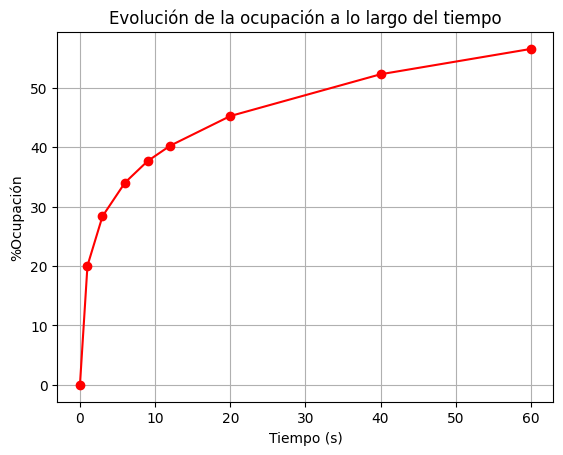

In [23]:
processes = {
    "adsorption": {"e_ads": 0.039, "e_int_abs": 0.035},
    "desorption": {"e_des": 0.272, "e_int_des": 0.272},
    "diffusion": {"e_diff": 0.272, "e_int_diff": 0.069}
}
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 727

# Puedes ajustar time_factor para controlar el salto temporal efectivo
time_factor = 1e-7  # valores mayores -> menos eventos por unidad de "tiempo simulado"

# =========================
#   Ejecución ejemplo
# =========================
lattice = HexagonalLattice(size=lattice_size)
kmc = KineticMonteCarlo(lattice, T=T, processes=processes, time_array=time_array, time_factor=time_factor)

_ = kmc.run_simulation()
gif_path = kmc.make_gif("evolucion_kmc2.gif", step=1, dpi=110, duration_ms=220)
print("GIF generado:", gif_path)

plt.plot(time_array, kmc.occupancy.values(), marker='o', color='red')
plt.xlabel("Tiempo (s)")
plt.ylabel("%Ocupación")
plt.title("Evolución de la ocupación a lo largo del tiempo")
plt.grid()
plt.show()

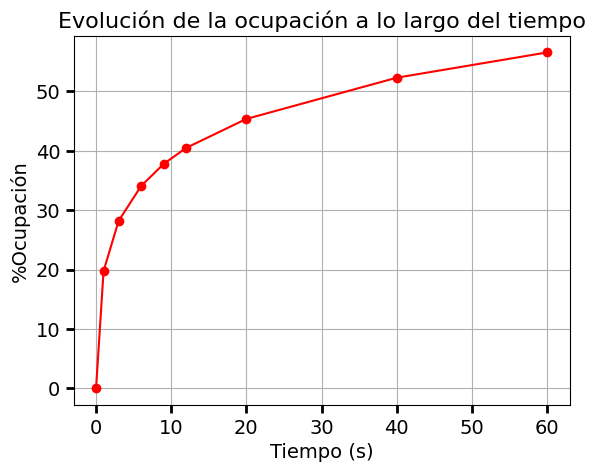

In [15]:
plt.plot(time_array, kmc.occupancy.values(), marker='o', color='red')
plt.xlabel("Tiempo (s)")
plt.ylabel("%Ocupación")
plt.title("Evolución de la ocupación a lo largo del tiempo")
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
plt.xlabel("Tiempo (s)", fontsize=14)
plt.ylabel("%Ocupación", fontsize=14)
plt.title("Evolución de la ocupación a lo largo del tiempo", fontsize=16)
plt.show()


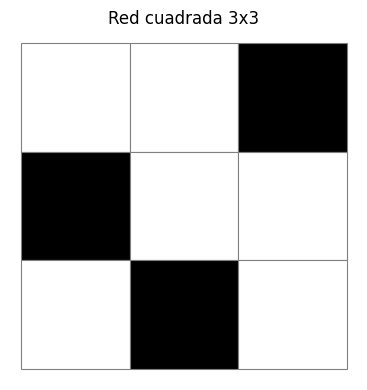

In [21]:
square_lattice = SquareLattice(size=3)
square_lattice.initialize()

square_lattice.lattice[1,0] = 1
square_lattice.lattice[0,2] = 1
square_lattice.lattice[2,1] = 1
square_lattice.plot(title="Red cuadrada 3x3", figsize=(4, 4))

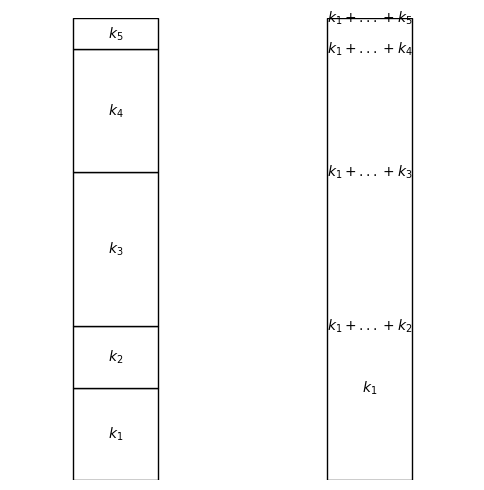

In [22]:
import matplotlib.pyplot as plt

# Tasas de ejemplo
rates = [3, 2, 5, 4, 1]
cum_rates = [sum(rates[:i+1]) for i in range(len(rates))]

fig, ax = plt.subplots(1, 2, figsize=(6,6))

# ---- Panel Izquierdo ----
y = 0
for i, k in enumerate(rates):
    ax[0].bar(0.5, k, bottom=y, width=0.4, edgecolor="black", facecolor="white")
    ax[0].text(0.5, y + k/2, f"$k_{i+1}$", ha="center", va="center")
    y += k
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,y)
ax[0].axis("off")

# ---- Panel Derecho ----
y = 0
for i, s in enumerate(cum_rates):
    ax[1].text(0.5, s, f"$k_1 + ... + k_{i+1}$" if i>0 else "$k_1$", 
               ha="center", va="center")
ax[1].bar(0.5, sum(rates), width=0.4, edgecolor="black", facecolor="white")
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,sum(rates))
ax[1].axis("off")

plt.show()


In [12]:
processes = {
    "adsorption": {"e_ads": 0.080, "e_int_abs": 0.040},
    "desorption": {"e_des": 0.272, "e_int_des": 0.111},
    "diffusion": {"e_diff": 0.187, "e_int_diff": 0.160}
}
T = 300
time_array = np.array([i for i in range(60)], dtype=float)
lattice_size = 600

# Puedes ajustar time_factor para controlar el salto temporal efectivo
time_factor = 1e-7  # valores mayores -> menos eventos por unidad de "tiempo simulado"

# =========================
#   Ejecución ejemplo
# =========================
lattice = HexagonalLattice(size=lattice_size)
kmc = KineticMonteCarlo(lattice, T=T, processes=processes, time_array=time_array, time_factor=time_factor)

_ = kmc.run_simulation()
gif_path = kmc.make_gif("evolucion_kmc3.gif", step=1, dpi=110, duration_ms=220)
print("GIF generado:", gif_path)


GIF generado: evolucion_kmc3.gif
